In [120]:
"""
Low-Volatility Rotating Portfolio (5 slots)
------------------------------------------
* Universe: NIFTY 50
* Signal:   “top-5 lowest 6-month σ AND price > 200-DMA”  (re-evaluated daily)
* Weighting: equal among the active names each day
* Risk:     skip entries when VIX > 30   |   stop each leg at –10 %
* Engine:   Pure pandas (Backtesting.py runs single-ticker stats only)
            → final portfolio P/L is stitched from per-ticker equity curves.
"""

import yfinance as yf
import pandas as pd
import numpy as np
from backtesting import Backtest, Strategy

# ----------------------------------------------------------------------
# 1 ─ Download price data and VIX
# ----------------------------------------------------------------------
TICKERS = [
    "RELIANCE.NS", "TCS.NS", "HDFCBANK.NS", "INFY.NS", "ICICIBANK.NS",
    "HINDUNILVR.NS", "SBIN.NS", "KOTAKBANK.NS", "BHARTIARTL.NS", 
    "ITC.NS", "LT.NS", "ASIANPAINT.NS", "AXISBANK.NS", "MARUTI.NS",
    "WIPRO.NS", "SUNPHARMA.NS", "DIVISLAB.NS", "TECHM.NS", "TITAN.NS",
    "ONGC.NS", "NTPC.NS", "ULTRACEMCO.NS", "POWERGRID.NS", "HCLTECH.NS",
    "BPCL.NS", "EICHERMOT.NS", "TATAMOTORS.NS", "GRASIM.NS", "JSWSTEEL.NS",
    "INDUSINDBK.NS", "COALINDIA.NS", "HDFCLIFE.NS", "BRITANNIA.NS", "SBILIFE.NS",
    "CIPLA.NS", "ADANIPORTS.NS", "TATACONSUM.NS", "DRREDDY.NS", "HEROMOTOCO.NS",
    "SHREECEM.NS", "BPCL.NS", "IOC.NS", "HINDALCO.NS", "M&M.NS",
    "NTPC.NS", "BAJAJ-AUTO.NS", "TECHM.NS", "INDIGO.NS", "JSWSTEEL.NS"
]
START, END = "2020-01-01", "2025-12-30"

# Adjusted close prices (splits/divs handled automatically)
prices = (yf.download(TICKERS, START, END, progress=False)['Close'])#.dropna(how="all"))
vix = (yf.download("^INDIAVIX", START, END, progress=False)['Close'].reindex(prices.index).ffill())

In [121]:
len(TICKERS)

49

In [122]:
# ----------------------------------------------------------------------
# 2 ─ Pre-compute indicators
# ----------------------------------------------------------------------

# === Strategy parameters ===
VOL_WINDOW      = 90          # look-back (trading days) for volatility
MA_WINDOW       = 150          # look-back for trend filter (simple MA)
MAX_POSITIONS   = 5           # maximum number of assets held
STOP_LOSS_PCT   = -0.10       # stop loss (-10 %)
VIX_THRESHOLD   = 25        # optional VIX filter (not used below)
MAX_HOLD_DAYS   = 90          # maximum holding period

# === Indicator calculations ===
daily_returns  = prices.pct_change()
annual_vol     = daily_returns.rolling(VOL_WINDOW).std() * np.sqrt(252)  # annualised σ
trend_ma       = prices.rolling(MA_WINDOW).mean()                        # 20-day SMA

# ───────────────────────────────────────────────────────────────
# 3.  Asset-selection helper
# ───────────────────────────────────────────────────────────────
def pick_low_volatility_assets(
        vol_row:   pd.Series,
        price_row: pd.Series,
        ma_row:    pd.Series,
        n: int = MAX_POSITIONS
) -> pd.Series:
    """
    Decide which symbols enter the portfolio on *one* date.

    Steps
    -----
    1. **Trend filter**  – only trade symbols whose price is above their
       moving average (up-trend).
    2. **Volatility rank** – among those, rank by realised volatility
       (lower is better).
    3. **Selection** – return a boolean Series that is *True* for the
       `n` lowest-volatility symbols, *False* otherwise.

    Parameters
    ----------
    vol_row   : annualised volatility for this date (one row of `annual_vol`)
    price_row : prices for this date (one row of `prices`)
    ma_row    : moving averages for this date (one row of `trend_ma`)
    n         : how many symbols to pick (default: MAX_POSITIONS)
    """
    # 1. Trend filter
    in_uptrend = price_row > ma_row

    # 2. Rank (NaNs for out-of-trend symbols are ignored)
    ranked_vol = vol_row.where(in_uptrend).rank(method="first")

    # 3. Select the `n` smallest ranks
    winners = ranked_vol.nsmallest(n).index

    return pd.Series(price_row.index.isin(winners), index=price_row.index)


# ───────────────────────────────────────────────────────────────
# 4.  Build the daily signal matrix
#     True  → symbol qualifies for today’s low-vol basket
# ───────────────────────────────────────────────────────────────
signals = pd.DataFrame(
    [
        pick_low_volatility_assets(
            annual_vol.loc[date],
            prices.loc[date],
            trend_ma.loc[date]
        )
        for date in prices.index
    ],
    index=prices.index,
    columns=prices.columns,
).astype(bool)

In [123]:
signals

Ticker      ADANIPORTS.NS  ASIANPAINT.NS  AXISBANK.NS  BAJAJ-AUTO.NS  \
Date                                                                   
2020-01-01           True           True         True           True   
2020-01-02           True           True         True           True   
2020-01-03           True           True         True           True   
2020-01-06           True           True         True           True   
2020-01-07           True           True         True           True   
...                   ...            ...          ...            ...   
2025-10-09          False          False        False          False   
2025-10-10          False          False        False          False   
2025-10-13          False          False        False          False   
2025-10-14          False          False        False          False   
2025-10-15          False          False        False          False   

Ticker      BHARTIARTL.NS  BPCL.NS  BRITANNIA.NS  CIPLA.NS  COALINDIA.NS  \
Date                                                                       
2020-01-01           True    False         False     False         False   
2020-01-02           True    False         False     False         False   
2020-01-03           True    False         False     False         False   
2020-01-06           True    False         False     False         False   
2020-01-07           True    False         False     False         False   
...                   ...      ...           ...       ...           ...   
2025-10-09          False    False         False     False          True   
2025-10-10          False    False         False     False          True   
2025-10-13          False    False         False     False          True   
2025-10-14          False    False         False     False         False   
2025-10-15          False    False         False     False          True   

Ticker      DIVISLAB.NS  ...  SBIN.NS  SHREECEM.NS  SUNPHARMA.NS  \
Date                     ...                                       
2020-01-01        False  ...    False        False         False   
2020-01-02        False  ...    False        False         False   
2020-01-03        False  ...    False        False         False   
2020-01-06        False  ...    False        False         False   
2020-01-07        False  ...    False        False         False   
...                 ...  ...      ...          ...           ...   
2025-10-09        False  ...     True        False         False   
2025-10-10        False  ...     True        False         False   
2025-10-13        False  ...     True        False         False   
2025-10-14        False  ...     True        False         False   
2025-10-15        False  ...     True        False         False   

Ticker      TATACONSUM.NS  TATAMOTORS.NS  TCS.NS  TECHM.NS  TITAN.NS  \
Date                                                                   
2020-01-01          False          False   False     False     False   
2020-01-02          False          False   False     False     False   
2020-01-03          False          False   False     False     False   
2020-01-06          False          False   False     False     False   
2020-01-07          False          False   False     False     False   
...                   ...            ...     ...       ...       ...   
2025-10-09          False          False   False     False     False   
2025-10-10          False          False   False     False     False   
2025-10-13          False          False   False     False     False   
2025-10-14          False          False   False     False     False   
2025-10-15          False          False   False     False     False   

Ticker      ULTRACEMCO.NS  WIPRO.NS  
Date                                 
2020-01-01          False     False  
2020-01-02          False     False  
2020-01-03          False     False  
2020-01-06          False     False  
2020-01-07          Fals

In [124]:
signals.sum().sort_values(ascending=False)

Ticker
BRITANNIA.NS     544
SUNPHARMA.NS     542
ITC.NS           508
ICICIBANK.NS     459
TCS.NS           371
HDFCBANK.NS      355
BHARTIARTL.NS    340
BAJAJ-AUTO.NS    326
HINDUNILVR.NS    319
ASIANPAINT.NS    318
INFY.NS          306
DRREDDY.NS       270
MARUTI.NS        229
HDFCLIFE.NS      191
ULTRACEMCO.NS    187
AXISBANK.NS      181
SBILIFE.NS       175
TITAN.NS         160
ADANIPORTS.NS    153
CIPLA.NS         149
LT.NS            104
KOTAKBANK.NS      99
NTPC.NS           96
SBIN.NS           83
TATACONSUM.NS     82
RELIANCE.NS       77
POWERGRID.NS      68
IOC.NS            63
DIVISLAB.NS       61
BPCL.NS           58
GRASIM.NS         55
SHREECEM.NS       54
JSWSTEEL.NS       40
COALINDIA.NS      39
HCLTECH.NS        35
HEROMOTOCO.NS     23
ONGC.NS           20
WIPRO.NS          12
INDIGO.NS          9
EICHERMOT.NS       7
TECHM.NS           5
M&M.NS             2
TATAMOTORS.NS      0
INDUSINDBK.NS      0
HINDALCO.NS        0
dtype: int64

In [125]:
# ----------------------------------------------------------------------
# 3 ─ Single-stock back-test (Backtesting.py) following its own Signal
# ----------------------------------------------------------------------
from backtesting import Strategy
import math, numpy as np

class SignalFollower(Strategy):
    # ────────── parameters you may tweak ──────────
    n_slots      = MAX_POSITIONS      # max simultaneous holdings
    stop_pct     = STOP_LOSS_PCT   # per-trade stop (%); None → disable
    vix_level    = VIX_THRESHOLD    # e.g. 30 blocks new entries; None → ignore
    max_holding  = MAX_HOLD_DAYS      # force-close after N bars
    # ------------------------------------------------

    def init(self):
        self.bar_clock     = 0        # global bar counter
        self.entry_bar_idx = None     # remembers when current pos opened

    # ------------------------------------------------
    def next(self):
        self.bar_clock += 1

        # 1) stop-loss
        if self.stop_pct is not None:
            for tr in self.trades:            # only open trades
                if tr.pl_pct < self.stop_pct:
                    tr.close()

        # 2) age-out after max_holding bars
        if self.position and self.entry_bar_idx is not None:
            if self.bar_clock - self.entry_bar_idx >= self.max_holding:
                self.position.close()
                self.entry_bar_idx = None

        # 3) entry / exit
        in_sig = bool(self.data.Signal[-1])
        vix_block = (self.vix_level is not None and
                     self.data.VIX[-1] > self.vix_level)

        if in_sig and not self.position and not vix_block:
            alloc_cash = self._broker._cash / self.n_slots   # ← fixed here
            price      = self.data.Close[-1]
            shares     = int(alloc_cash / price)
            if shares < 1:
                return
            self.buy(size=shares)
            self.entry_bar_idx = self.bar_clock

        elif (not in_sig) and self.position:
            self.position.close()
            self.entry_bar_idx = None

    # ------------------------------------------------
    def stop(self):
        # ensure last open counts in "# Trades"
        if self.position:
            self.position.close()


In [126]:
# ----------------------------------------------------------------------
# 4 ─ Run one Backtest per ticker, collect stats & equity curves
# ----------------------------------------------------------------------
stats, curves = {}, []

for ticker in TICKERS:
    sig = signals[ticker].reindex(prices.index).ffill()

    df = pd.DataFrame({
        'Close' : prices[ticker].squeeze(),
        'Signal': signals[ticker].squeeze(),
        'VIX'   : vix.squeeze()
    })
    
    df = (df.assign(Open=df['Close'], High=df['Close'], Low=df['Close'])
            [['Open','High','Low','Close','Signal','VIX']]
            .dropna())

    bt = Backtest(df, SignalFollower, cash=100000, commission=0.001)
    s  = bt.run()
    stats[ticker] = s
    curves.append(s['_equity_curve']['Equity'].rename(ticker))


In [127]:
# ------------------------------------------------------------------
# 5 ─ Build the portfolio equity curve (sum $-P/L across slots)
# ------------------------------------------------------------------
INIT_CAP  = 100_000          # total capital of the book
# SLOT_CAP  = INIT_CAP / MAX_POSITIONS

equity_df = pd.concat(curves, axis=1)          #   one col per ticker
# Each column starts at 100k but only ever puts 20k at risk.
pl_df     = equity_df.sub(INIT_CAP)            #   isolate slot P/L ($)
total_pl  = pl_df.sum(axis=1)                  #   add the five slots
PORT_EQ   = INIT_CAP + total_pl                #   true portfolio equity
port_ret  = PORT_EQ.pct_change().fillna(0)  

In [128]:
# ──────────────────────────────────────────────────────────────────────
# 6 ─ Summary table
# ──────────────────────────────────────────────────────────────────────
def sharpe(r):
    return r.mean() / r.std() * np.sqrt(252)

summary = pd.DataFrame({
    "Return [%]":  (PORT_EQ.iloc[-1] / PORT_EQ.iloc[0] - 1) * 100,
    "Sharpe Ratio": sharpe(port_ret),
    "Max DD [%]": 100 * (PORT_EQ.cummax() - PORT_EQ).max()
                       / PORT_EQ.cummax().max(),
    "# Trades":   signals.diff().abs().sum().sum()
}, index=["Portfolio"])

print("=== Portfolio summary ===")
print(summary.round(2))


=== Portfolio summary ===
           Return [%]  Sharpe Ratio  Max DD [%]  # Trades
Portfolio       78.06          0.95       13.57      1432


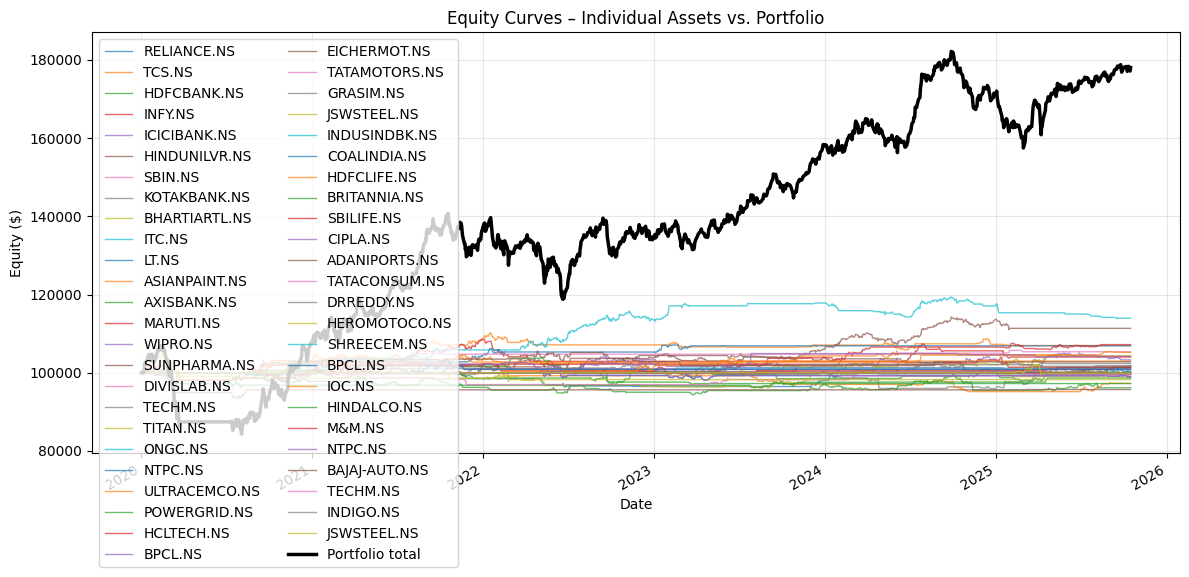

In [129]:
import plotly.graph_objects as go
import matplotlib.pyplot as plt

# 1) Gather individual curves into one DataFrame
equity_curves = pd.concat(curves, axis=1)        # cols = tickers
equity_curves.columns.name = "Symbol"

# 2) Plot
fig, ax = plt.subplots(figsize=(12, 6))

# -- Individual assets (thin, semi-transparent)
equity_curves.plot(ax=ax, lw=1.0, alpha=0.7)

# -- Portfolio total (thicker, darker line)
PORT_EQ.plot(ax=ax, color="black", lw=2.5, label="Portfolio total")

# 3) Cosmetics
ax.set_title("Equity Curves – Individual Assets vs. Portfolio")
ax.set_ylabel("Equity ($)")
ax.grid(True, alpha=0.3)
ax.legend(loc="upper left", ncol=2)

plt.tight_layout()
plt.show()

In [130]:
import plotly.graph_objects as go

fig = go.Figure()

# Individual curves
for col in equity_curves.columns:
    fig.add_trace(go.Scatter(
        x=equity_curves.index, y=equity_curves[col],
        mode="lines", name=col, line=dict(width=3)))

# Portfolio total
fig.add_trace(go.Scatter(
    x=PORT_EQ.index, y=PORT_EQ,
    mode="lines", name="Portfolio total", line=dict(width=6, color="white")))

fig.update_layout(
    title="Equity Curves – Individual Assets vs. Portfolio",
    xaxis_title="Date", yaxis_title="Equity ($)",
    plot_bgcolor='black',
    xaxis=dict(showgrid=False),
    yaxis=dict(showgrid=False),
    legend=dict(orientation="h", yanchor="bottom", y=1.02),
    width=1200, height=800)  # Updated figure size

fig.show()


In [131]:
# ────────────────────────────────────────────────────────────────
# 7 ─ Per-ticker headline metrics + diagnostics
# ────────────────────────────────────────────────────────────────
wanted = ["Return [%]", "Sharpe Ratio", "Max. Drawdown [%]", "# Trades"]

# ①  Pull headline numbers from Backtesting.py
per_ticker = (
    pd.DataFrame({t: {m: s[m] for m in wanted}
                  for t, s in stats.items()})
      .T
)

# ②  Days the stock qualified for the basket   (signal == True)
per_ticker["Days in basket"] = signals.sum()

# ③  Days that ALSO passed the VIX filter
vix_ok   = (vix <= VIX_THRESHOLD).to_numpy().reshape(-1, 1)   # (n_days, 1)
eligible = signals & vix_ok                               # DataFrame[bool]
per_ticker["Days VIX≤limit"] = eligible.sum()

# ④  Distinct entry SET-UPS  (False→True transitions of ‘eligible’)
entry_setups = (eligible & ~eligible.shift(fill_value=False)).sum()
per_ticker["Entry setups"] = entry_setups

# ⑤  Actual holding days   (duration of open trades)
held = {}
for t in TICKERS:
    trades = stats[t]["_trades"]
    held[t] = 0 if trades.empty else (trades["ExitBar"] - trades["EntryBar"] + 1).sum()
per_ticker["Days held"] = pd.Series(held)

# ⑥  Arrange columns & sort
cols = wanted + ["Entry setups", "Days held", "Days VIX≤limit", "Days in basket"]
per_ticker = per_ticker[cols].sort_values("Return [%]", ascending=False)

print("\n=== Single-ticker stats (with diagnostics) ===")
per_ticker.round(2)



=== Single-ticker stats (with diagnostics) ===


Return [%]  Sharpe Ratio  Max. Drawdown [%]  # Trades  \
ITC.NS              13.95          0.84              -4.64      38.0   
SUNPHARMA.NS        11.35          0.72              -2.88      34.0   
MARUTI.NS            7.19          1.00              -1.54      22.0   
TCS.NS               6.96          0.54              -3.98      29.0   
LT.NS                6.88          0.90              -1.46      10.0   
DIVISLAB.NS          5.36          1.17              -0.57      13.0   
ULTRACEMCO.NS        5.20          0.64              -2.56      32.0   
BHARTIARTL.NS        4.25          0.27              -8.51      39.0   
HDFCLIFE.NS          4.22          0.38              -2.20      18.0   
CIPLA.NS             4.17          0.45              -2.29      22.0   
INFY.NS              4.02          0.35              -5.39      23.0   
ICICIBANK.NS         3.28          0.26              -3.08      32.0   
IOC.NS               2.97          0.55              -1.61       5.0   
BAJAJ-AUTO.NS        2.77          0.23              -3.94      25.0   
GRASIM.NS            2.34          0.52              -1.17      10.0   
ONGC.NS              1.86          0.58              -0.33       4.0   
HINDUNILVR.NS        1.69          0.15              -4.35      33.0   
INDIGO.NS            1.64          0.80              -0.14       2.0   
SBILIFE.NS           1.54          0.16              -2.39      30.0   
SBIN.NS              1.54          0.31              -1.90       9.0   
HCLTECH.NS           1.40          0.19              -2.48       8.0   
EICHERMOT.NS         1.29          0.60              -0.31       5.0   
RELIANCE.NS          1.24          0.14              -3.90      14.0   
WIPRO.NS             1.02          0.47              -0.60       7.0   
BPCL.NS              0.85          0.15              -2.47       6.0   
HDFCBANK.NS          0.43          0.04              -4.31      32.0   
COALINDIA.NS         0.22          0.10              -0.97       4.0   
SHREECEM.NS          0.00           NaN              -0.00       0.0   
TATAMOTORS.NS        0.00           NaN              -0.00       0.0   
INDUSINDBK.NS        0.00           NaN              -0.00       0.0   
HINDALCO.NS          0.00           NaN              -0.00       0.0   
JSWSTEEL.NS         -0.09          0.00              -2.60       3.0   
M&M.NS              -0.12          0.00              -0.33       2.0   
TECHM.NS            -0.29          0.00              -0.62       5.0   
DRREDDY.NS          -0.36          0.00              -3.82      21.0   
KOTAKBANK.NS        -0.39          0.00              -4.48      20.0   
TATACONSUM.NS       -0.79          0.00              -3.18      10.0   
TITAN.NS            -1.01          0.00              -3.52       8.0   
NTPC.NS             -1.13          0.00              -2.39      19.0   
AXISBANK.NS         -1.35          0.00              -4.59      12.0   
HEROMOTOCO.NS       -1.76          0.00              -2.24       8.0   
ASIANPAINT.NS       -2.72          0.00              -6.66      28.0   
POWERGRID.NS        -2.77          0.00              -6.51      16.0   
BRITANNIA.NS        -3.86          0.00              -5.63      46.0   
ADANIPORTS.NS       -4.30          0.00              -7.06       4.0   

               Entry setups  Days held  Days VIX≤limit  Days in basket  
ITC.NS                   38        535             496             508  
SUNPHARMA.NS             37        575             525             542  
MARUTI.NS                22        251             229             229  
TCS.NS                   31        399             366             371  
LT.NS                    11        113             102             104  
DIVISLAB.NS              13         73              60              61  
ULTRACEMCO.NS            33        217             185             187  
BHARTIARTL.NS            43        298             242             340  
HDFCLIFE.NS              22        208       

In [132]:

import plotly.graph_objects as go

fig = go.Figure()

# Individual curves
for col in equity_curves.columns:
    fig.add_trace(go.Scatter(
        x=equity_curves.index, y=equity_curves[col],
        mode="lines", name=col, line=dict(width=3)))

fig.update_layout(
    title="Equity Curves – Individual Assets vs. Portfolio",
    xaxis_title="Date", yaxis_title="Equity ($)",
    plot_bgcolor='black',
    xaxis=dict(showgrid=False),
    yaxis=dict(showgrid=False),
    legend=dict(orientation="h", yanchor="bottom", y=1.02),
    width=1200, height=800)  # Updated figure size

fig.show()


In [133]:
vix.describe()

Ticker    ^INDIAVIX
count   1434.000000
mean      17.695035
std        7.765400
min        9.890000
25%       13.210000
50%       15.630000
75%       20.245000
max       83.610001